In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

import os
import glob
import sys

%matplotlib inline

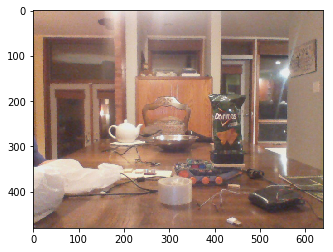

In [2]:
train_img = scipy.ndimage.imread('../data_collection/images/img_0.jpg')
plt.imshow(train_img)

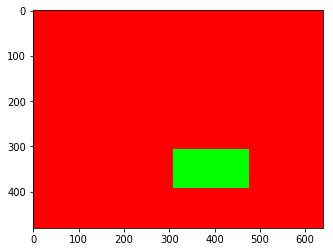

In [3]:
mask_img = scipy.ndimage.imread('../data_collection/masks/img_mask_0.jpg')
plt.imshow(mask_img)

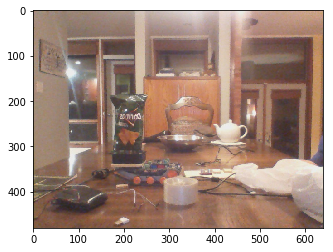

In [4]:
flipped = scipy.ndimage.imread('../data_collection/images/img_flipped_0.jpg')
plt.imshow(flipped)

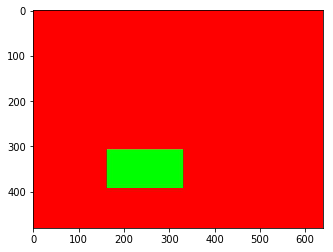

In [5]:
flipped_msk = scipy.ndimage.imread('../data_collection/masks/img_flipped_mask_0.jpg')
plt.imshow(flipped_msk)

In [6]:
mask_img.shape

(480, 640, 3)

# Batches

In [7]:
class RoverImageIterator:
    
    def __init__(self, num_rover_images, img_dir, msk_dir):
        self.num_rover_images = num_rover_images
        self.img_dir = img_dir
        self.msk_dir = msk_dir
        
        self.iterator = 0
        self.img_pairs = []
        
    
    # creates a list of file name / mask name pairs and shuffles them.
    # these will be used to create the batches during training.
    def setup_rover_iterator(self):
        
        # reset the iterator
        self.iterator = 0
        self.img_pairs = []
        
        for i in range(self.num_rover_images):
            img_std_file = self.img_dir + "img_" + str(i) + ".jpg"
            img_flp_file = self.img_dir + "img_flipped_" + str(i) + ".jpg"
            img_msk_file = self.msk_dir + "img_mask_" + str(i) + ".jpg"
            img_flp_msk_file = self.msk_dir + "img_flipped_mask_" + str(i) + ".jpg"
            
            self.img_pairs.append( (img_std_file, img_msk_file) )
            self.img_pairs.append( (img_flp_file, img_flp_msk_file) )
        
        np.random.shuffle(self.img_pairs)
        
    
    def next_batch(self, batch_size):
        batch_files = self.img_pairs[self.iterator:self.iterator+batch_size]
        self.iterator += batch_size
        
        images = []
        masks = []
        
        for img_file, msk_file in batch_files:
            img = scipy.ndimage.imread(img_file) / 255 # normalize inputs
            msk = scipy.ndimage.imread(msk_file)
            
            images.append(img)
            masks.append(msk)
    
        return images, masks
        

In [8]:
rover_image_iterator = RoverImageIterator(10, '../data_collection/images/', '../data_collection/masks/')

In [9]:
rover_image_iterator.setup_rover_iterator()

In [10]:
images, masks = rover_image_iterator.next_batch(10)

In [11]:
images[5]

array([[[ 0.79215686,  0.63137255,  0.54509804],
        [ 0.79215686,  0.63921569,  0.50980392],
        [ 0.79607843,  0.65098039,  0.48627451],
        ..., 
        [ 0.61176471,  0.54901961,  0.41960784],
        [ 0.59607843,  0.56470588,  0.41176471],
        [ 0.59607843,  0.58431373,  0.41568627]],

       [[ 0.80784314,  0.64705882,  0.56078431],
        [ 0.8       ,  0.64313725,  0.54117647],
        [ 0.79607843,  0.64705882,  0.50588235],
        ..., 
        [ 0.62745098,  0.54901961,  0.44313725],
        [ 0.61960784,  0.56862745,  0.44313725],
        [ 0.61176471,  0.58039216,  0.43921569]],

       [[ 0.80392157,  0.64313725,  0.56470588],
        [ 0.8       ,  0.63921569,  0.56078431],
        [ 0.80392157,  0.64313725,  0.55686275],
        ..., 
        [ 0.63529412,  0.55686275,  0.4627451 ],
        [ 0.63137255,  0.56078431,  0.4745098 ],
        [ 0.62745098,  0.56470588,  0.4745098 ]],

       ..., 
       [[ 0.45490196,  0.36862745,  0.31764706],
        

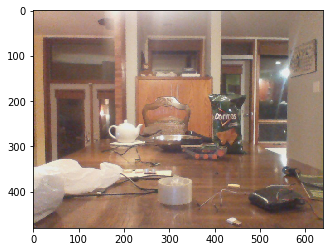

In [12]:
plt.imshow(images[5])

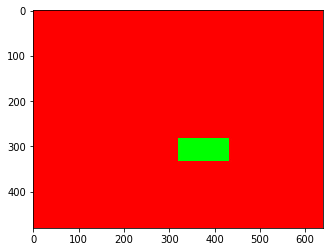

In [13]:
plt.imshow(masks[5])

# Helper Functions

In [14]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [15]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return init_bias_vals

In [16]:
def cov2d(x, W):
    # x shape [batch_size, height, width, channels]
    # W shape [ filter H, filter W, Ch In, Ch Out ]
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

In [17]:
def max_pooling_2by2(x):
    # x shape [batch, height, width, channels]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [18]:
def convolutional_layer(x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    
    return tf.nn.relu(cov2d(x, W) + b)

In [19]:
# create convolutional layer followed by max pooling.  
# Kernel size is assumed to be symetric (so kernel size = 3 creates a 3x3 kernel)
# Input Tensor: [None, Image_height, Image_width, num_channels]
# Output Tensor: [None, 0.5 * Image_Height, 0.5 * Image_Width, num_filters]
def encoder_layer(x, kernel_size, num_channels, num_filters):
    layer = convolutional_layer(x, [kernel_size, kernel_size, num_channels, num_filters])
    layer_max_pool = max_pooling_2by2(layer)
    
    return layer_max_pool

In [20]:
# generates the values for a bilinear upsample filter kernel.  This was taken from
# http://warmspringwinds.github.io/tensorflow/tf-slim/2016/11/22/upsampling-and-image-segmentation-with-tensorflow-and-tf-slim/
def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)

In [21]:
# Create filter for use of the conv2d_transpose method in tensorflow for use in the decoder layers.
# this filter assumes we are upscaling the input by a factor of 2.
# this was adapted from http://warmspringwinds.github.io/tensorflow/tf-slim/2016/11/22/upsampling-and-image-segmentation-with-tensorflow-and-tf-slim/
def bilinear_upsample_weights(input_channels, output_channels):
    
    filter_size = 4
    
    weights = np.zeros((filter_size,
                        filter_size,
                        output_channels,
                        input_channels), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(input_channels):
        for j in range(output_channels):
            weights[:, :, j, i] = upsample_kernel
    
    return weights
    
    

In [22]:
# decoder layer upsamples input from the previous layer, then performs a convolution
# operation on that layer.  Parameters are similar to those used for the encoder layer.
# Input Tensor Shape: [None, Image_Height, Image_Width, Channels]
# Output Tensor Shape: [None, 2*Image_Height, 2_Image_Width, Filters]
def decoder_layer(x, num_channels, num_filters):
    x_shape = tf.shape(x)
    batch_size = x_shape[0]
    height = x_shape[1]
    width = x_shape[2]
    
    upsample_filter_np = bilinear_upsample_weights(num_channels, num_filters)
    up_filter = tf.constant(upsample_filter_np)
    
    layer = tf.nn.conv2d_transpose(x, up_filter, output_shape=[batch_size, 2*height, 2*width, num_filters], strides=[1, 2, 2, 1])
    return layer

# FCN Model

In [23]:
# build model
def fcn_model(x):
    # Input: [None, 480, 640, 3]
    # Output: [None, 240, 320, 32]
    encoder_layer1 = encoder_layer(x=x, kernel_size=3, num_channels=3, num_filters=32)
    
    # Input: [None, 240, 320, 32]
    # Output: [None, 120, 160, 64]
    encoder_layer2 = encoder_layer(x=encoder_layer1, kernel_size=3, num_channels=32, num_filters=64)
    
    # 1x1 Convolution
    # Input [None, 120, 160, 64]
    # Output [None, 120, 160, 128]
    one_by_one = convolutional_layer(x=encoder_layer2, shape=[1, 1, 64, 128])
    
    # Input [None, 120, 160, 128]
    # Output [None, 240, 320, 64]
    decoder_layer1 = decoder_layer(x=one_by_one, num_channels=128, num_filters=64)
    
    # Input [None, 240, 320, 64]
    # Output [None, 480, 640, 32]
    decoder_layer2 = decoder_layer(x=decoder_layer1, num_channels=64, num_filters=32)
    
    # Final convolution to produce an output image
    output = convolutional_layer(x=decoder_layer2, shape=[3, 3, 32, 3])
    
    return output
    
    

In [24]:
# constants
learning_rate = 0.002
num_iterations = 1000
batch_size = 1 # not a lot of memory on my laptop and not much of a gpu


In [25]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, 480, 640, 3])
y = tf.placeholder(tf.float32, shape=[None, 480, 640, 3])

In [26]:
model = fcn_model(x)

In [27]:
loss = tf.reduce_mean(tf.square(model - y))

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_iterations):
        x_batch, y_batch = rover_image_iterator.next_batch(batch_size=batch_size)
        
        sess.run(train, feed_dict={x: x_batch, y:y_batch})
        
        print ("Iteration: ", iteration)
        